# Background #

Over the past year, a company has experienced a high failure rate in online credit card payments, resulting in significant financial losses and increasing customer dissatisfaction with the online shopping experience. These payments are managed through four different payment service providers (PSPs) (=payments service providers), with the company paying transaction fees for each payment. Currently, the routing logic used to assign a PSP to a transaction is manual and rule-based. It is believed that by using predictive modeling, I can help to reduce the failure rate problem, reduce expenses and raise customer satisfaction. 
A well established methodology for model building is used in this project, Cross-Industry Standard Process for Data Mining (CRISP-DM) consists of business understanding, data understanding, data preparation, modeling, evaluation and deployment. Before any model is trained, it's essential to assess the quality of the data, as poor data quality can degrade model performance. Various techniques are employed to address low-quality data and devise new feature variables that leverage both data and domain knowledge. Feature selection will focus on optimizing model performance. In addition to building the machine learning model, I am providing interpretable results, error analysis, the approach limitations, to ensure the robustness of my solution. 
The ultimate aim is to generate insights by data analysis, and to develop a predictive model that automates the PSP routing process, enhances the payment success rate, and keeps transaction fees low.



### This is a project task to fulfill a master degree in data science, IU university of applied science, Germany.
Author: Amr abuzeid

amr.maak87@gmail.com

amr.abuzeid@iu-study.org

In [1187]:
import warnings
from IPython.display import display
#data exploration, visualization, preparation and cleaning
import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype
import matplotlib.pyplot as plt
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

import seaborn as sns
import plotly.graph_objects as go
from ptitprince import PtitPrince as pt


# building ML models and model selection
from sklearn.feature_selection import  mutual_info_classif
from sklearn.model_selection import train_test_split
from xgboost import  XGBClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, fbeta_score, confusion_matrix
from sklearn.preprocessing import MinMaxScaler,  OneHotEncoder
from sklearn.naive_bayes import MultinomialNB
import joblib
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
# Set Matplotlib defaults

# Mute warnings
warnings.filterwarnings('ignore')


In [1188]:
def plot_sanky(df, source_feature, destination_feature):
    """plot sanky diagram counts between two categorical features, 
    df: pandas dataframe table,
    source_feature: start of the flowing direction (text)
     destination_feature: end of the flowing direction (text))"""
    counts = df.value_counts([source_feature, destination_feature]).reset_index(name='count')

    # Create a mapping for the labels
    labels = list(counts[source_feature].unique()) + list(counts[destination_feature].unique())
    source_indices = [labels.index(row[source_feature]) for _, row in counts.iterrows()]
    target_indices = [labels.index(row[destination_feature]) + len(counts[source_feature].unique()) for _, row in counts.iterrows()]

    # Create the Sankey diagram
    fig = go.Figure(data=[go.Sankey(
        node=dict(
            pad=15,
            thickness=20,
            line=dict(color="black", width=0.5),
            label=labels,
            color=["blue"] * len(counts[source_feature].unique()) + ["orange"] * len(counts[destination_feature].unique())
        ),
        link=dict(
            source=source_indices,
            target=target_indices,
            value=counts['count'].tolist()
        )
    )])

    fig.update_layout(title_text=f"Sankey Diagram counts from {source_feature} to {destination_feature}", font_size=10)
    fig.show()

###  Data understanding and Feature Extraction ###
Extract as many features as I can to be encluded in exploratory data analysis and visualizations.

1-upload data, rename column, explore different data types.

2- drop duplicates.

3- extract features

4- incorporate fee table into the dataframe.

5- categorical variables frequency visualization

6- categorical variables relation with success visualization

7- continuous variable visualization, exploration and outlier removal.

8- Sankey Diagram.


In [1189]:
# df_raw = pd.read_excel(r'C:\Users\amr.mostafa\Downloads\1729148885806_PSP_Jan_Feb_2019.xlsx', index_col=0)
df_raw = pd.read_excel(r'C:\Users\amrma\Downloads\PSP_Jan_Feb_2019.xlsx', index_col=0)

In [1190]:
df=df_raw.copy()
display(df.head(1))
df.rename({'3D_secured': '_3D_secured'}, axis= 1, inplace=True)
display(df.info())
display('describe',df.describe())


,tmsp,country,amount,success,PSP,3D_secured,card
0,2019-01-01 00:01:11,Germany,89,0,UK_Card,0,Visa


<class 'pandas.core.frame.DataFrame'>
Int64Index: 50410 entries, 0 to 50409
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   tmsp         50410 non-null  datetime64[ns]
 1   country      50410 non-null  object        
 2   amount       50410 non-null  int64         
 3   success      50410 non-null  int64         
 4   PSP          50410 non-null  object        
 5   _3D_secured  50410 non-null  int64         
 6   card         50410 non-null  object        
dtypes: datetime64[ns](1), int64(3), object(3)
memory usage: 3.1+ MB


None

'describe'

,amount,success,_3D_secured
count,50410.000000,50410.000000,50410.000000
mean,202.395715,0.202896,0.238266
std,96.274730,0.402160,0.426027
min,6.000000,0.000000,0.000000
25%,133.000000,0.000000,0.000000
50%,201.000000,0.000000,0.000000
75%,269.000000,0.000000,0.000000
max,630.000000,1.000000,1.000000


In [1191]:
#investigating duplicates
display(df[df.duplicated(keep=False)].head(10))
display(df[df.duplicated(keep=False)].shape)
display(df.duplicated().sum())
#there are 81 rows duplicated twice (likely to be from false gathering, must be deleted

,tmsp,country,amount,success,PSP,_3D_secured,card
83,2019-01-01 01:28:02,Germany,37,0,UK_Card,0,Master
84,2019-01-01 01:28:02,Germany,37,0,UK_Card,0,Master
495,2019-01-01 09:35:38,Germany,170,0,UK_Card,0,Diners
496,2019-01-01 09:35:38,Germany,170,0,UK_Card,0,Diners
499,2019-01-01 09:44:27,Germany,113,0,UK_Card,0,Visa
500,2019-01-01 09:44:27,Germany,113,0,UK_Card,0,Visa
602,2019-01-01 11:32:44,Germany,170,0,UK_Card,0,Visa
603,2019-01-01 11:32:44,Germany,170,0,UK_Card,0,Visa
1392,2019-01-02 03:06:14,Austria,229,0,UK_Card,0,Master
1393,2019-01-02 03:06:14,Austria,229,0,UK_Card,0,Master


(162, 7)

81

In [1192]:
# delete  duplicated rows (exactly in all columns)
df.drop_duplicates(inplace=True)
display(df[df.duplicated(keep=False)].shape)

(0, 7)

In [1193]:
# Extract date, hour, minute, and second
def extract_date(df): #written as a function because it will be frequently used 
    df['tmsp']=pd.to_datetime(df['tmsp'])
    df['date'] = df['tmsp'].dt.date
    df['date']=pd.to_datetime(df['date'])
    return df

df=extract_date(df)
df['hour'] = df['tmsp'].dt.hour
df['minute'] = df['tmsp'].dt.minute
df['second'] = df['tmsp'].dt.second

In [1194]:
df['date']=pd.to_datetime(df['date'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50329 entries, 0 to 50409
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   tmsp         50329 non-null  datetime64[ns]
 1   country      50329 non-null  object        
 2   amount       50329 non-null  int64         
 3   success      50329 non-null  int64         
 4   PSP          50329 non-null  object        
 5   _3D_secured  50329 non-null  int64         
 6   card         50329 non-null  object        
 7   date         50329 non-null  datetime64[ns]
 8   hour         50329 non-null  int64         
 9   minute       50329 non-null  int64         
 10  second       50329 non-null  int64         
dtypes: datetime64[ns](2), int64(6), object(3)
memory usage: 4.6+ MB


In [1195]:
#delete trials with the same card, country, amount, and minute may be trial due to wrong password or insufficient credit
display(df[df.duplicated(subset=['country','amount', 'date','hour','minute','PSP','card' ],keep=False)])

,tmsp,country,amount,success,PSP,_3D_secured,card,date,hour,minute,second
0,2019-01-01 00:01:11,Germany,89,0,UK_Card,0,Visa,2019-01-01,0,1,11
1,2019-01-01 00:01:17,Germany,89,1,UK_Card,0,Visa,2019-01-01,0,1,17
12,2019-01-01 00:13:34,Austria,232,0,UK_Card,1,Diners,2019-01-01,0,13,34
13,2019-01-01 00:13:44,Austria,232,0,UK_Card,1,Diners,2019-01-01,0,13,44
19,2019-01-01 00:20:53,Germany,205,0,UK_Card,0,Master,2019-01-01,0,20,53
...,...,...,...,...,...,...,...,...,...,...,...
50382,2019-02-28 22:59:43,Germany,190,1,UK_Card,0,Visa,2019-02-28,22,59,43
50395,2019-02-28 23:30:05,Switzerland,23,0,UK_Card,0,Visa,2019-02-28,23,30,5
50396,2019-02-28 23:30:29,Switzerland,23,0,UK_Card,0,Visa,2019-02-28,23,30,29
50407,2019-02-28 23:47:04,Austria,91,0,UK_Card,0,Master,2019-02-28,23,47,4


In [1196]:
display(df)
df.drop_duplicates(subset=['country','amount', 'date','hour','minute','PSP','card' ],keep='last', inplace=True)
display(df)

,tmsp,country,amount,success,PSP,_3D_secured,card,date,hour,minute,second
0,2019-01-01 00:01:11,Germany,89,0,UK_Card,0,Visa,2019-01-01,0,1,11
1,2019-01-01 00:01:17,Germany,89,1,UK_Card,0,Visa,2019-01-01,0,1,17
2,2019-01-01 00:02:49,Germany,238,0,UK_Card,1,Diners,2019-01-01,0,2,49
3,2019-01-01 00:03:13,Germany,238,1,UK_Card,1,Diners,2019-01-01,0,3,13
4,2019-01-01 00:04:33,Austria,124,0,Simplecard,0,Diners,2019-01-01,0,4,33
...,...,...,...,...,...,...,...,...,...,...,...
50404,2019-02-28 23:45:39,Switzerland,415,0,UK_Card,0,Visa,2019-02-28,23,45,39
50406,2019-02-28 23:46:48,Austria,91,0,UK_Card,0,Master,2019-02-28,23,46,48
50407,2019-02-28 23:47:04,Austria,91,0,UK_Card,0,Master,2019-02-28,23,47,4
50408,2019-02-28 23:47:36,Austria,91,0,UK_Card,0,Master,2019-02-28,23,47,36


,tmsp,country,amount,success,PSP,_3D_secured,card,date,hour,minute,second
1,2019-01-01 00:01:17,Germany,89,1,UK_Card,0,Visa,2019-01-01,0,1,17
2,2019-01-01 00:02:49,Germany,238,0,UK_Card,1,Diners,2019-01-01,0,2,49
3,2019-01-01 00:03:13,Germany,238,1,UK_Card,1,Diners,2019-01-01,0,3,13
4,2019-01-01 00:04:33,Austria,124,0,Simplecard,0,Diners,2019-01-01,0,4,33
5,2019-01-01 00:06:41,Switzerland,282,0,UK_Card,0,Master,2019-01-01,0,6,41
...,...,...,...,...,...,...,...,...,...,...,...
50403,2019-02-28 23:43:36,Switzerland,208,0,Simplecard,0,Master,2019-02-28,23,43,36
50404,2019-02-28 23:45:39,Switzerland,415,0,UK_Card,0,Visa,2019-02-28,23,45,39
50406,2019-02-28 23:46:48,Austria,91,0,UK_Card,0,Master,2019-02-28,23,46,48
50408,2019-02-28 23:47:36,Austria,91,0,UK_Card,0,Master,2019-02-28,23,47,36


In [1197]:
#highlight in a separate new column which row is duplicated (repeated transaction in the following minute)
# considering that the dataset already sorted by the timestamp,
last_row_index=df.shape[0]-1
df['duplicated_first_trial']=np.nan
for each in range(last_row_index):                #iterate throgh row and test if the
    if df.iloc[each-1, 9] == df.iloc[each, 9]-1:  #minute value in a row equal the following minute minus one
        if ((df.iloc[each-1, [1,2,4,5,6,7,8]]) == (df.iloc[each, [1,2,4,5,6,7,8]])).sum() ==7: #and if it has same columns values
            df.iloc[each-1, 11]=1                   #then write in the new column ' 1'.

In [1198]:
# df.to_excel('jjj.xlsx')  # a quick look 

In [1199]:
#drop highlighted rows to delet trials, 
df.drop(df.query('duplicated_first_trial ==1').index, inplace=True)
# and drop other useless columns
df.drop('duplicated_first_trial', axis=1, inplace=True)
df.drop('minute', axis=1, inplace=True)
df.drop('second', axis=1, inplace=True)
df.shape

(40528, 9)

In [1200]:
#incorporate fees to the table

def incorporate_fee_into_table(df, success):
    """df argument as a Dataframe and define the column success name 
    which will insert fees accordingly, note that in the routing process, 
    we will use predicted success instead of the column success, 'string'"""
    fee = pd.DataFrame({
    'name': ['Moneycard', 'Goldcard', 'UK_Card', 'Simplecard'],
    'Fee on successful transactions(EURO)': [5, 10, 3, 1],
    'Fee on failed transactions': [2, 5, 1, 0.5]
      })
    df['fee']=np.nan
    for each in range(fee.shape[0]):
        df.loc[(df.PSP==fee.iloc[each, 0]) &( df[success]==1) , 'fee']=fee.iloc[each, 1] 
        # means if the first name in fee table equal the name of PSP and the transaction is successful, then write succesful fee. 
        df.loc[(df.PSP==fee.iloc[each, 0]) &( df[success]==0) , 'fee']=fee.iloc[each, 2] 
    return df

df=incorporate_fee_into_table(df,'success')
df.head(1)

,tmsp,country,amount,success,PSP,_3D_secured,card,date,hour,fee
1,2019-01-01 00:01:17,Germany,89,1,UK_Card,0,Visa,2019-01-01,0,3.0


In [1201]:
# extract week_name, day_type, month name, and day in month from date
def extracting_week_name(df):
    df['week_name']=df['date'].dt.day_name()
    df['week_name']=df['week_name'].astype('category')
    return df
def extracting_day_type(df):
    df['day_type'] = df['date'].apply(lambda x: 'Weekend' if x.weekday() >= 5 else 'Working Day')
    df['day_type']=df['day_type'].astype('category')
    return df
def extracting_month_name(df):
    df['month_name']=df['date'].dt.month_name()
    df['month_name']=df['month_name'].astype('category')
    return df
def extracting_day_in_month(df):
    df['dayinmonth'] = df['tmsp'].dt.day
    return df
df=extracting_week_name(df)
df=extracting_day_type(df)
df=extracting_month_name(df)
df=extracting_day_in_month(df)
df.head(1)

,tmsp,country,amount,success,PSP,_3D_secured,card,date,hour,fee,week_name,day_type,month_name,dayinmonth
1,2019-01-01 00:01:17,Germany,89,1,UK_Card,0,Visa,2019-01-01,0,3.0,Tuesday,Working Day,January,1


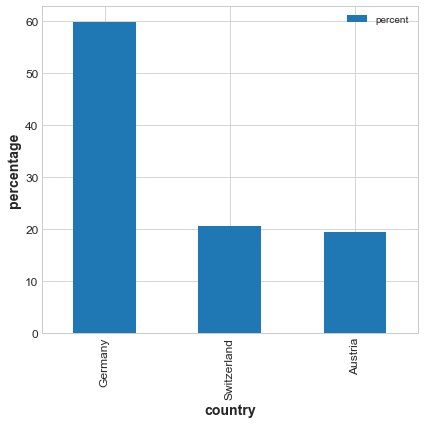

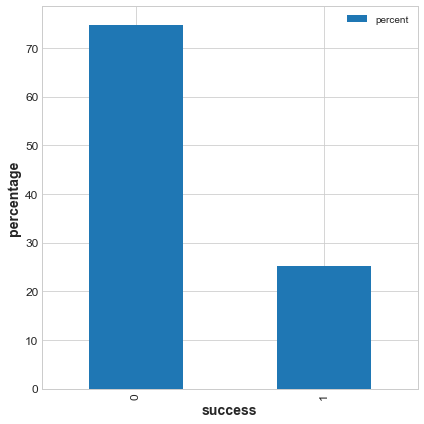

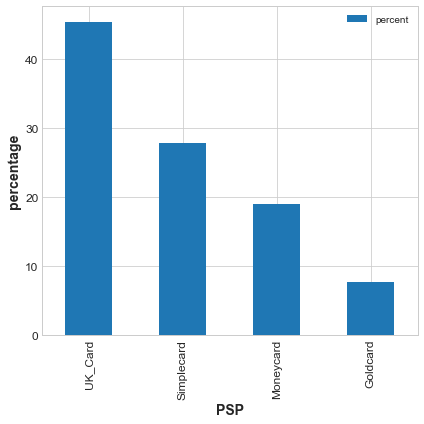

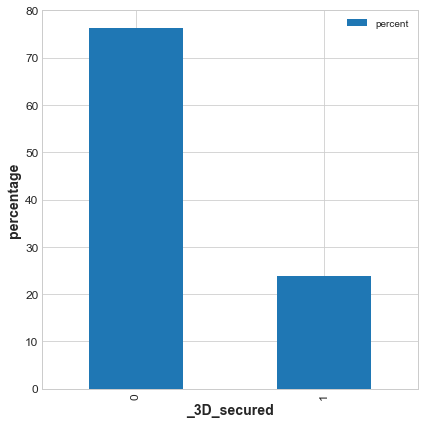

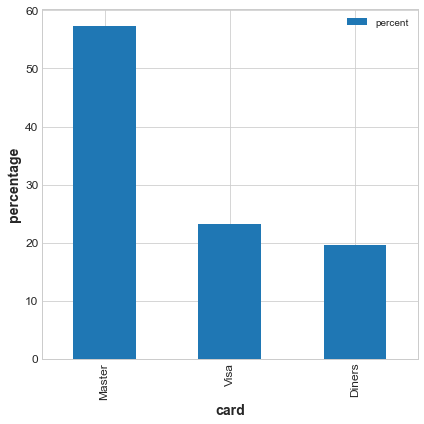

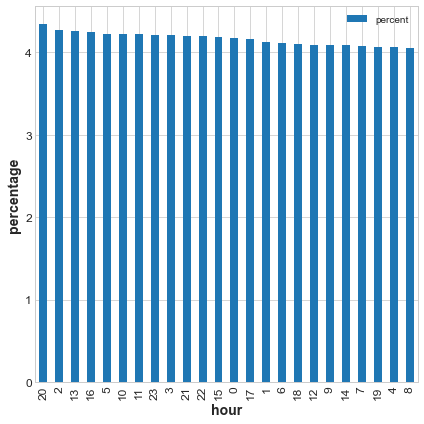

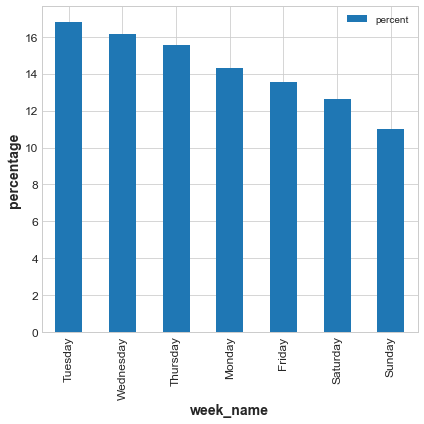

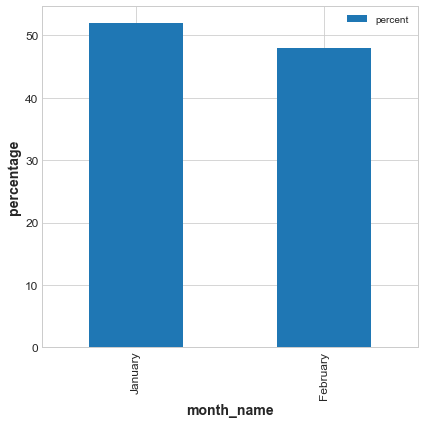

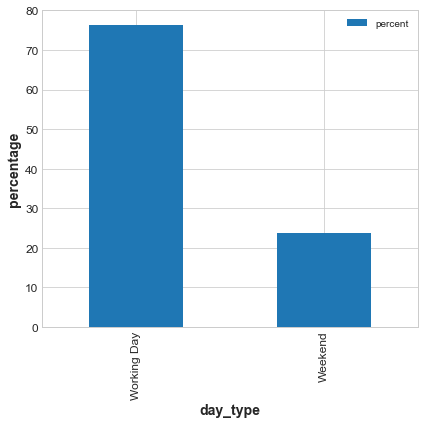

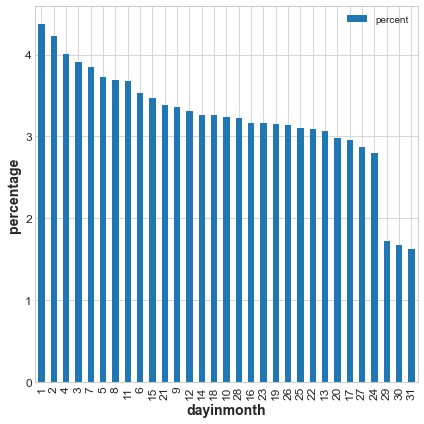

In [1202]:
# check frequencies of categories by percent
categorical_columns=[ 'country', 'success','PSP', '_3D_secured', 'card', 'hour', 'week_name', 'month_name','day_type' ,'dayinmonth']
for each in categorical_columns:
    ratio=pd.DataFrame(df[each].value_counts())
    ratio['percent']=(ratio[each]/ratio[each].sum())*100
    ratio.reset_index(inplace=True,)
    ratio.plot(x='index', y='percent', kind='bar', figsize=(6,6));
    plt.xlabel(each, fontsize=14)
    plt.ylabel('percentage', fontsize=14)
    plt.xticks(fontsize=12)  # X-ticks label size  
    plt.yticks(fontsize=12)  # Y-ticks label size 
for each in ['country', 'PSP', 'card']:
    df[each] = df[each].astype('category')

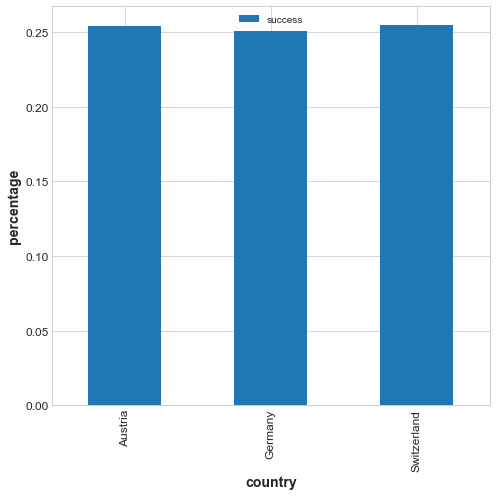

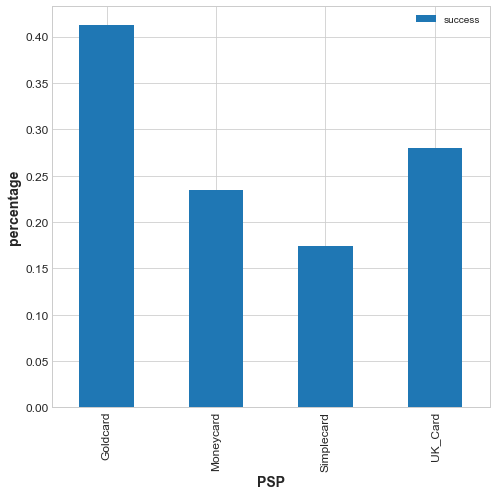

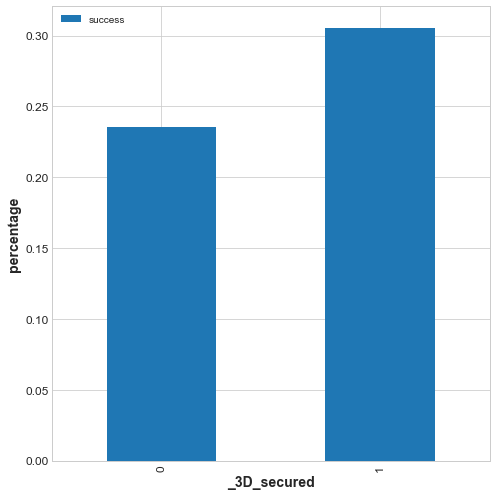

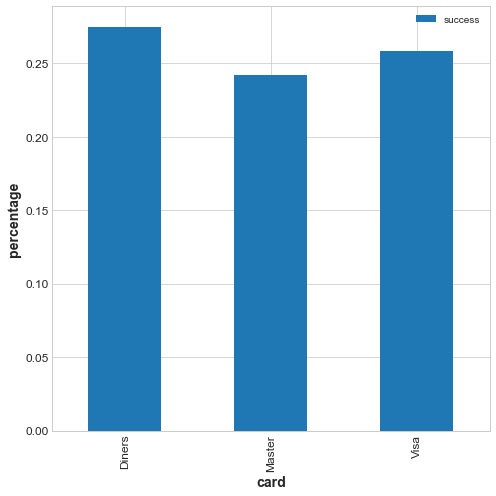

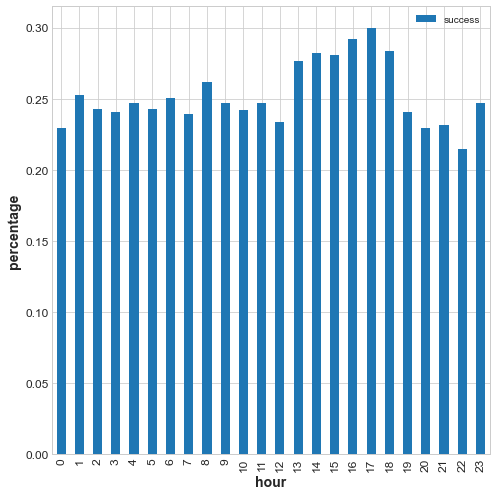

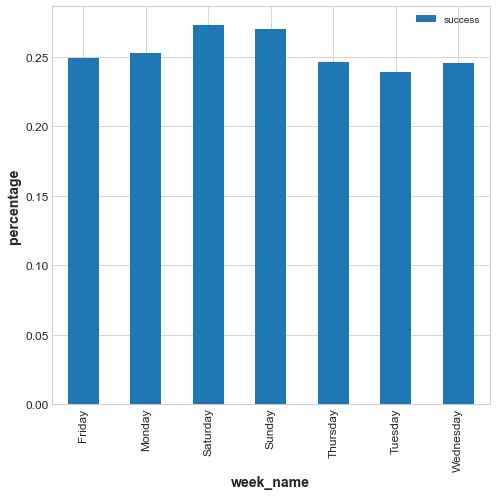

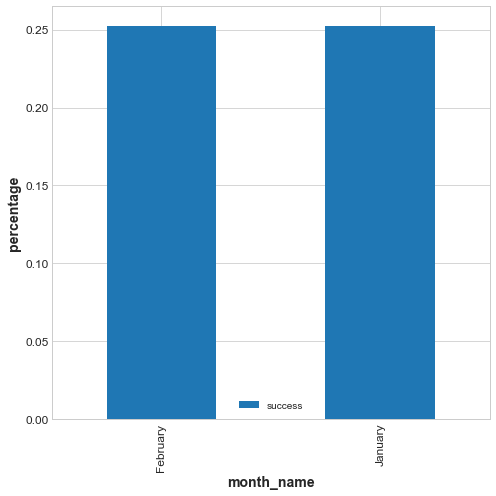

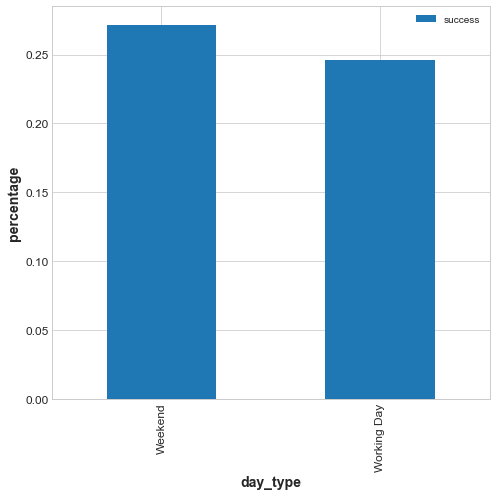

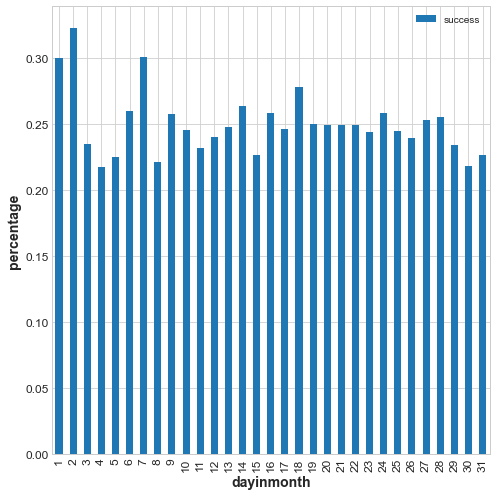

In [1203]:
#lets investigate between categorical variables and sucess rate,
for each in [ 'country','PSP', '_3D_secured', 'card', 'hour', 'week_name', 'month_name','day_type' ,'dayinmonth']:
    (df.groupby(each)['success'].mean().reset_index()).plot(x=each, y='success', kind='bar', figsize=(7,7));
    plt.xlabel(each, fontsize=14)
    plt.ylabel('percentage', fontsize=14)
    plt.xticks(fontsize=12)  # X-ticks label size  
    plt.yticks(fontsize=12)  # Y-ticks label size 

(array([   0., 1000., 2000., 3000., 4000., 5000., 6000.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

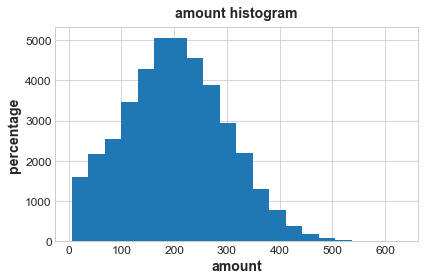

In [1204]:
# the only continuous variable is (amount)
df.amount.hist(bins=20)
plt.title('amount histogram')

plt.xlabel('amount' ,fontsize=14)
plt.ylabel('percentage', fontsize=14)
plt.xticks(fontsize=12)  # X-ticks label size  
plt.yticks(fontsize=12)  # Y-ticks label size 

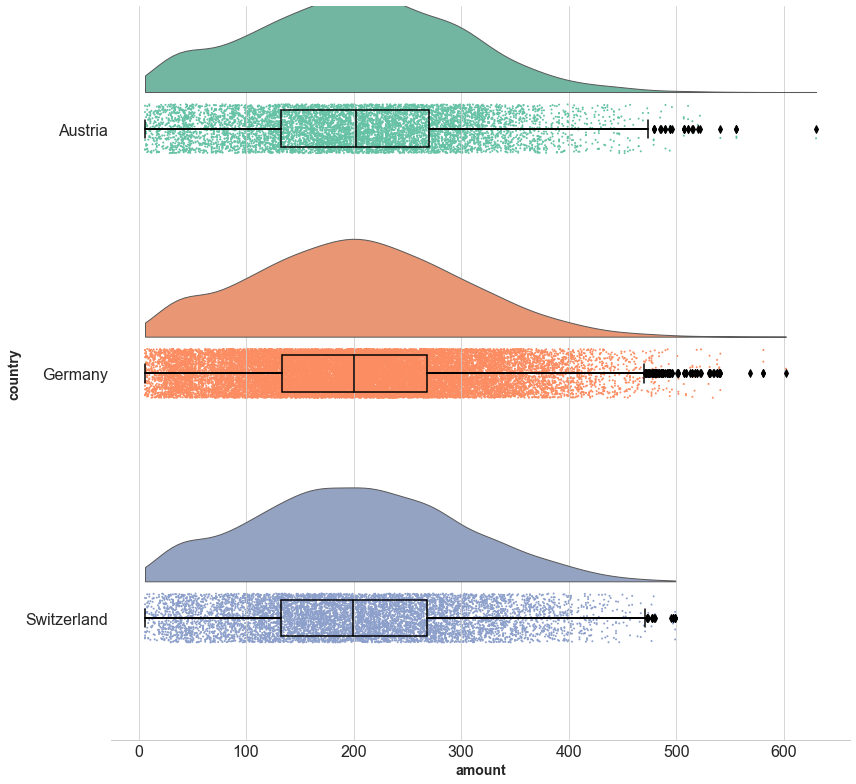

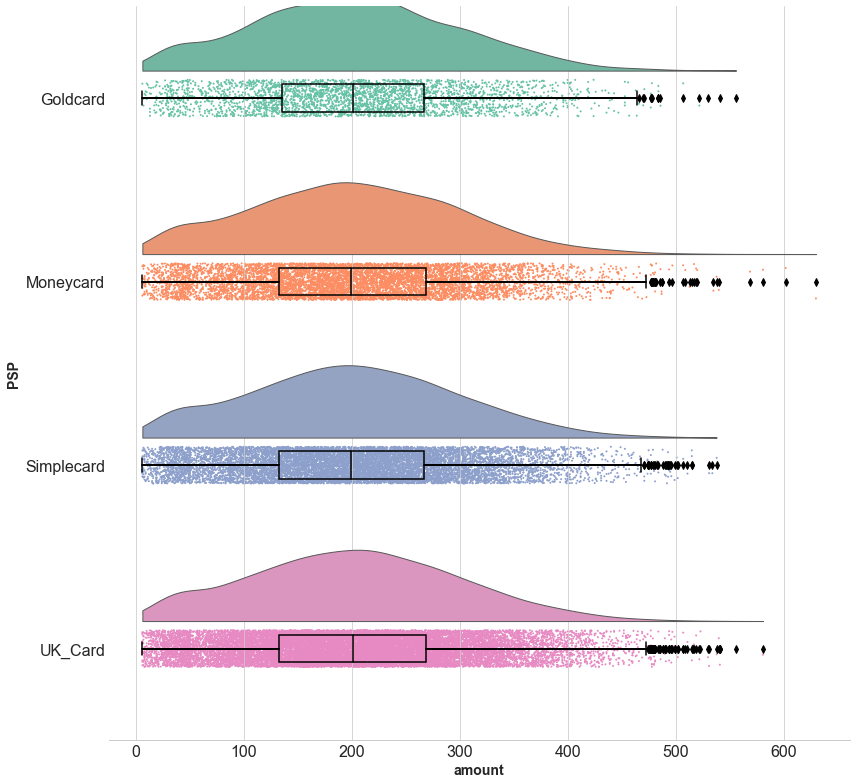

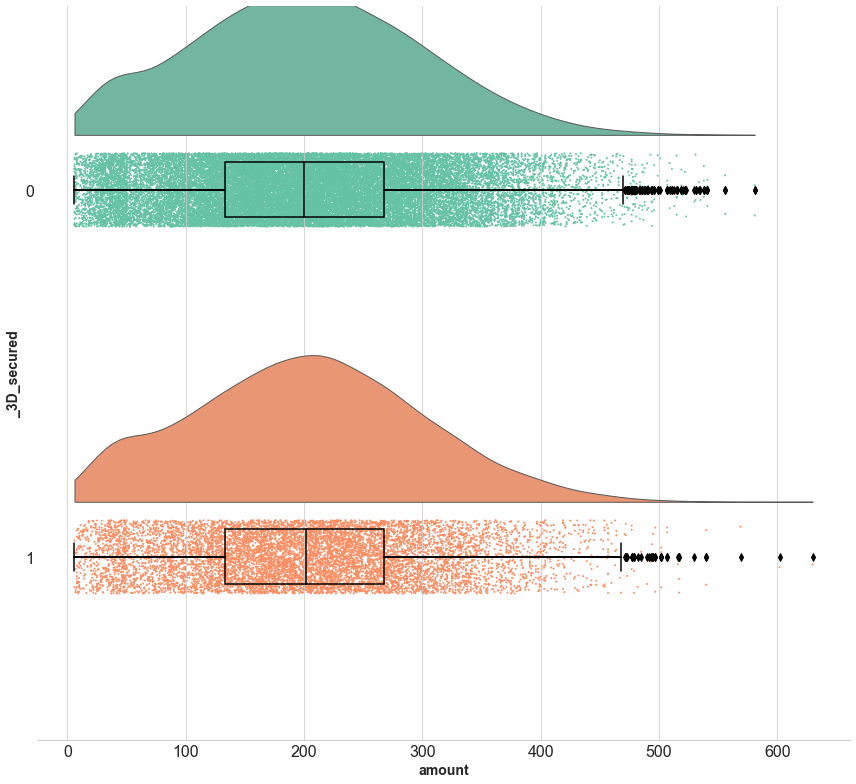

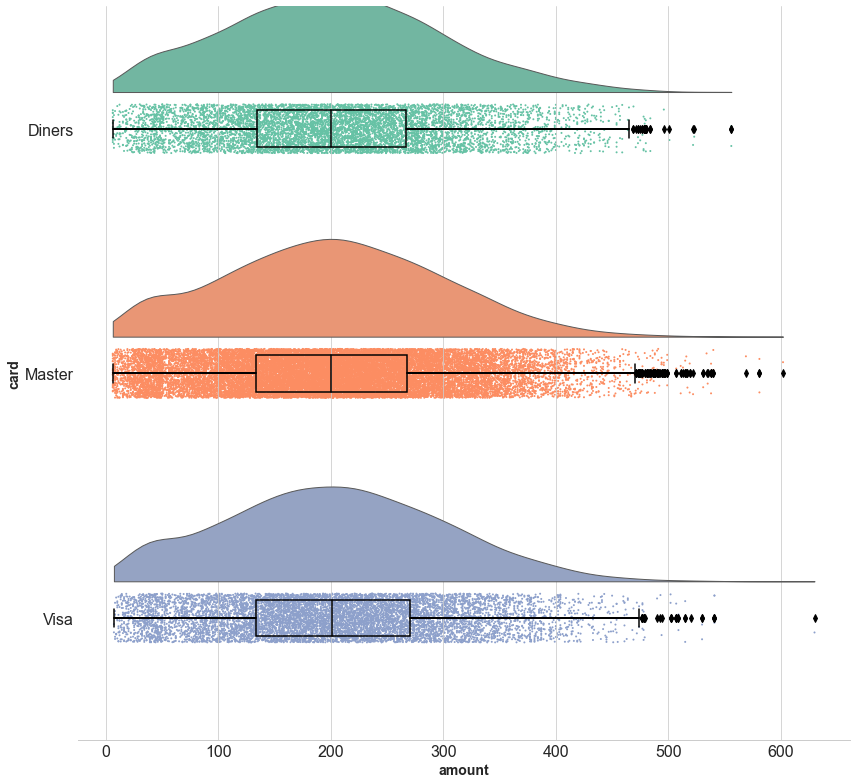

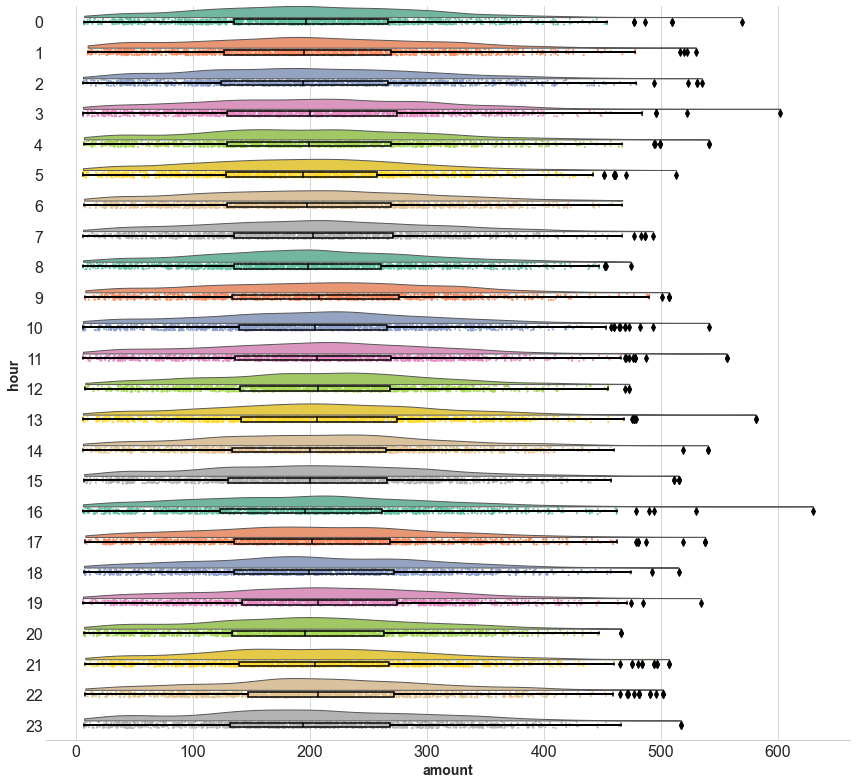

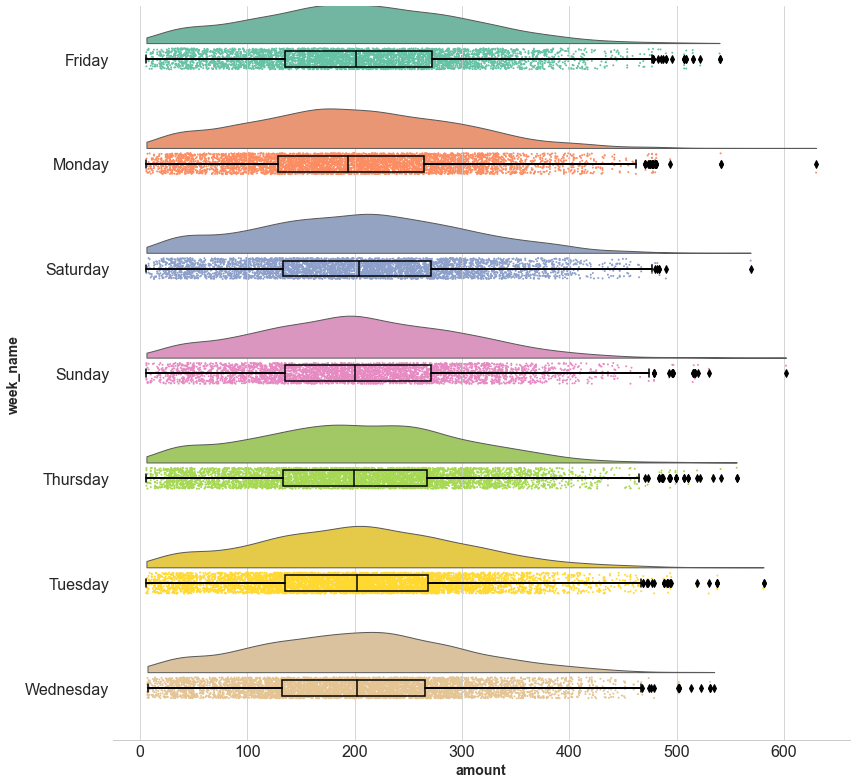

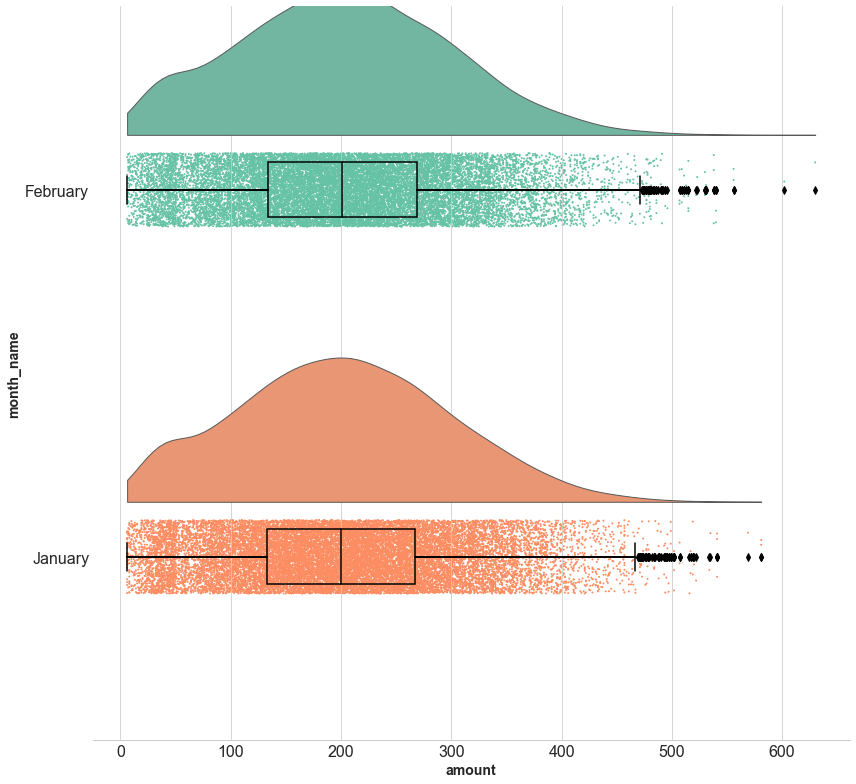

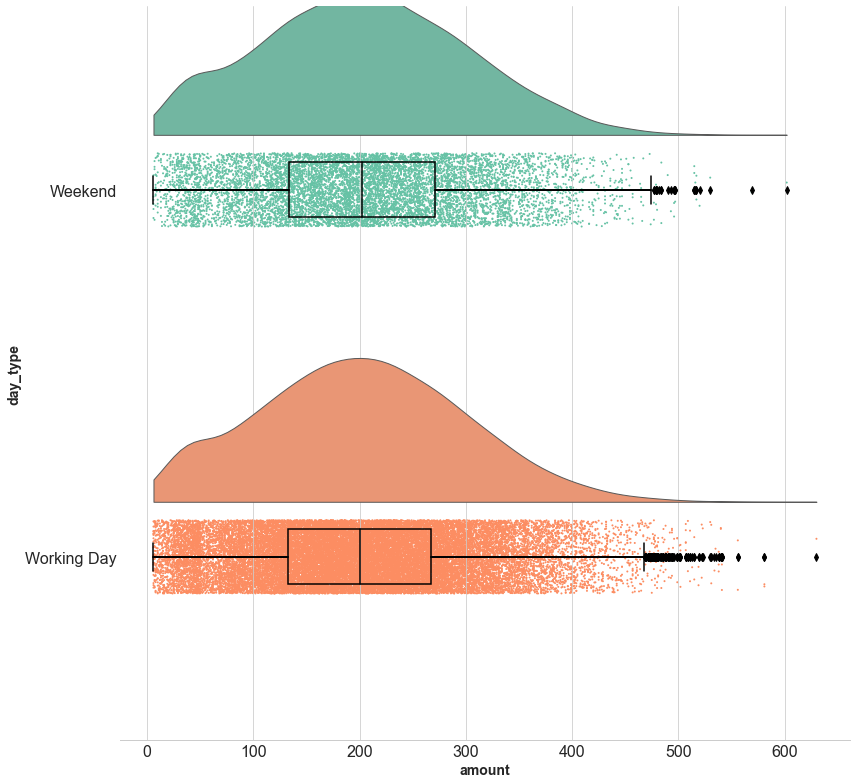

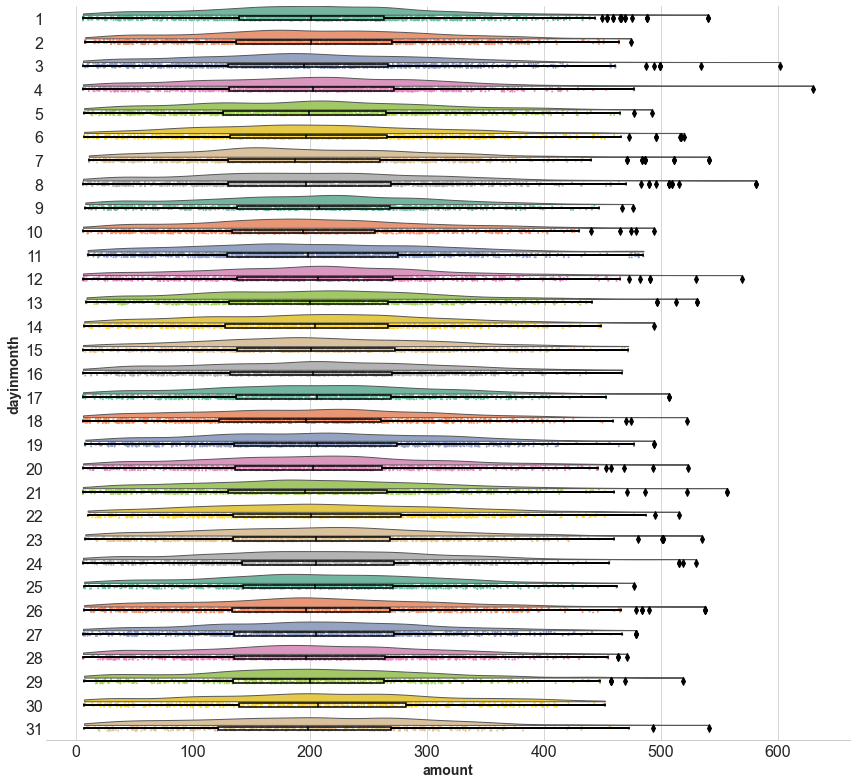

In [1205]:
# seeing (amount) outliers with respect to different categories
for each in [ 'country','PSP', '_3D_secured', 'card', 'hour', 'week_name', 'month_name','day_type' ,'dayinmonth']:
#     pt.RainCloud(df, x='amount', y=each)
    f, ax = plt.subplots(figsize=(12, 11))

    dx="amount"; dy=each; ort="h"
    ax=pt.half_violinplot(data=df, palette="Set2", bw=.2,  linewidth=1,cut=0.,\
                       scale="area", width=.8, inner=None,orient=ort,x=dx,y=dy)
    ax=sns.stripplot(data=df, palette="Set2", edgecolor="white",size=2,orient=ort,\
                     x=dx,y=dy,jitter=1,zorder=0)
    ax=sns.boxplot(data=df, color="black",orient=ort,width=.15,x=dx,y=dy,zorder=10,\
                  showcaps=True,boxprops={'facecolor':'none', "zorder":10},\
                   showfliers=True,whiskerprops={'linewidth':2, "zorder":10},saturation=1)
    plt.xlabel(dx, fontsize=14)  # Change fontsize to your desired size  
    plt.ylabel(dy, fontsize=14)  
    plt.xticks(fontsize=16)  # X-ticks label size  
    plt.yticks(fontsize=16)  # Y-ticks label size 
    # Finalize the figure
    #ax.set(ylim=(3.5, -.7))
    sns.despine(left=True)


In [1206]:
# it is likely save to remove amount outliers > 490
def drop_amount_outliers(df):
    df.drop(df.query('amount > 490').index, inplace=True)
    return df
df=drop_amount_outliers(df)

In [1207]:
#amount and success
relation_bet_amount_and_sucess=df.groupby('success')['amount'].mean().reset_index()
relation_bet_amount_and_sucess

,success,amount
0,0,207.154883
1,1,185.330296


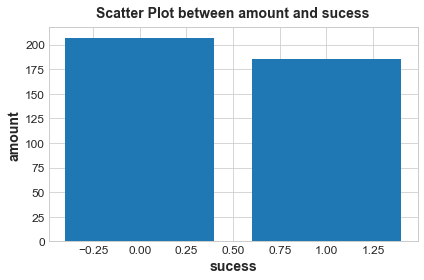

In [1208]:
plt.bar(relation_bet_amount_and_sucess['success'], relation_bet_amount_and_sucess['amount'])

# Add labels and title
plt.xlabel('sucess', fontsize=14)
plt.ylabel('amount', fontsize=14)



plt.xticks(fontsize=12)  # X-ticks label size  
plt.yticks(fontsize=12)  # Y-ticks label size 

plt.title('Scatter Plot between amount and sucess')

# Show plot
plt.show()

In [1209]:
# from the above analysis amount and PSP are considered significant features for sucess ratio
df.groupby('PSP')['amount'].mean()


PSP
Goldcard      202.698765
Moneycard     201.109685
Simplecard    200.646211
UK_Card       202.311386
Name: amount, dtype: float64

In [1210]:
# each PSP company provide around 200EURO for each card

In [1211]:
df.groupby(['PSP', 'card'])['amount'].mean().reset_index(name='mean')
# nearly the same amount used for different types of cards, for all PSP`s,
# may be it is something in the contract (eg. upper limit)

,PSP,card,mean
0,Goldcard,Diners,201.494656
1,Goldcard,Master,203.284156
2,Goldcard,Visa,202.394737
3,Moneycard,Diners,203.263772
4,Moneycard,Master,200.749435
5,Moneycard,Visa,200.118119
6,Simplecard,Diners,202.450509
7,Simplecard,Master,199.238117
8,Simplecard,Visa,202.709766
9,UK_Card,Diners,201.870986


(array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

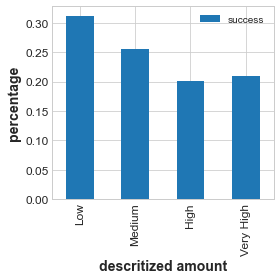

In [1212]:
# descritizing the amount to test a relation with success.
df['descritized_amount'] = pd.cut(df['amount'], bins=4, labels=[ 'Low', 'Medium', 'High', 'Very High'])
(df.groupby('descritized_amount')['success'].mean().reset_index()).plot(x='descritized_amount', y='success', kind='bar', figsize=(4,4));
plt.xlabel('descritized amount', fontsize=14)
plt.ylabel('percentage',  fontsize=14)




plt.xticks(fontsize=12)  # X-ticks label size  
plt.yticks(fontsize=12)  # Y-ticks label size 

In [1213]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40461 entries, 1 to 50409
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   tmsp                40461 non-null  datetime64[ns]
 1   country             40461 non-null  category      
 2   amount              40461 non-null  int64         
 3   success             40461 non-null  int64         
 4   PSP                 40461 non-null  category      
 5   _3D_secured         40461 non-null  int64         
 6   card                40461 non-null  category      
 7   date                40461 non-null  datetime64[ns]
 8   hour                40461 non-null  int64         
 9   fee                 40461 non-null  float64       
 10  week_name           40461 non-null  category      
 11  day_type            40461 non-null  category      
 12  month_name          40461 non-null  category      
 13  dayinmonth          40461 non-null  int64     

In [1214]:
df.head()

,tmsp,country,amount,success,PSP,_3D_secured,card,date,hour,fee,week_name,day_type,month_name,dayinmonth,descritized_amount
1,2019-01-01 00:01:17,Germany,89,1,UK_Card,0,Visa,2019-01-01,0,3.0,Tuesday,Working Day,January,1,Low
3,2019-01-01 00:03:13,Germany,238,1,UK_Card,1,Diners,2019-01-01,0,3.0,Tuesday,Working Day,January,1,Medium
4,2019-01-01 00:04:33,Austria,124,0,Simplecard,0,Diners,2019-01-01,0,0.5,Tuesday,Working Day,January,1,Low
5,2019-01-01 00:06:41,Switzerland,282,0,UK_Card,0,Master,2019-01-01,0,1.0,Tuesday,Working Day,January,1,High
6,2019-01-01 00:07:19,Switzerland,282,0,Simplecard,0,Master,2019-01-01,0,0.5,Tuesday,Working Day,January,1,High


In [1215]:
df['descritized_amount'] = pd.cut(df['amount'], bins=5, labels=[ 'Low', 'Medium', 'High', 'Very High', 'high_outliers'])

(array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

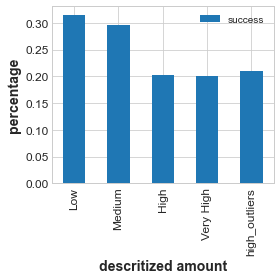

In [1216]:
(df.groupby('descritized_amount')['success'].mean().reset_index()).plot(x='descritized_amount', y='success', kind='bar', figsize=(4,4));
plt.xlabel('descritized amount', fontsize=14)
plt.ylabel('percentage', fontsize=14)

plt.xticks(fontsize=12)  # X-ticks label size  
plt.yticks(fontsize=12)  # Y-ticks label size 

In [1217]:
df.groupby(['PSP', 'card']).size().reset_index(name='count')
# Master card is always more frequently used in all PSP`s than other types of cards

,PSP,card,count
0,Goldcard,Diners,655
1,Goldcard,Master,1742
2,Goldcard,Visa,760
3,Moneycard,Diners,1543
4,Moneycard,Master,4426
5,Moneycard,Visa,1744
6,Simplecard,Diners,2162
7,Simplecard,Master,6522
8,Simplecard,Visa,2560
9,UK_Card,Diners,3550


In [1218]:
# may be creating feature interaction between PSP and card would be useful, 
# like concatenating the name strings of them together
def interaction_PSP_card(df):
    
    df['PSP_card_interaction']= df['PSP'].str.cat(df['card'], sep='_')
    df['PSP_card_interaction']=df['PSP_card_interaction'].astype('category')
    return df

df=interaction_PSP_card(df)

(array([0. , 0.1, 0.2, 0.3, 0.4, 0.5]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

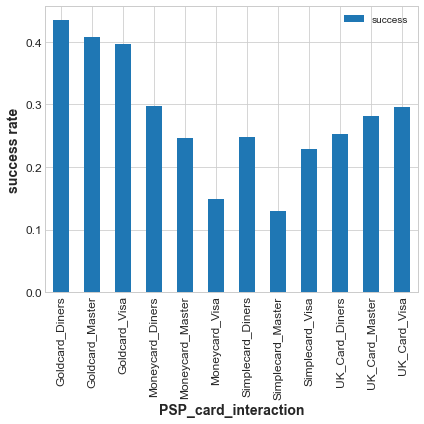

In [1219]:
(df.groupby('PSP_card_interaction')['success'].mean().reset_index()).plot(x='PSP_card_interaction', y='success', kind='bar', figsize=(6,6));
# it is found that it really has a great effect 
plt.xlabel('PSP_card_interaction', fontsize=14)
plt.ylabel('success rate', fontsize=14)

plt.xticks(fontsize=12)  # X-ticks label size  
plt.yticks(fontsize=12)  # Y-ticks label size 

In [1220]:
df.columns

Index(['tmsp', 'country', 'amount', 'success', 'PSP', '_3D_secured', 'card',
       'date', 'hour', 'fee', 'week_name', 'day_type', 'month_name',
       'dayinmonth', 'descritized_amount', 'PSP_card_interaction'],
      dtype='object')

In [1221]:
# plot_sanky(df,'success', '_3D_secured' )
plot_sanky(df,'success', 'PSP' )

# these columns are tested against success : 'country',  'success', 'PSP', '_3D_secured', 'card',
#         'hour',  'week_name', 'day_type', 'month_name',
#        'dayinmonth', 'descritized_amount', 'PSP_card_interaction'

In [1222]:
df.month_name.unique()

['January', 'February']
Categories (2, object): ['January', 'February']

In [1223]:
df.head()

,tmsp,country,amount,success,PSP,_3D_secured,card,date,hour,fee,week_name,day_type,month_name,dayinmonth,descritized_amount,PSP_card_interaction
1,2019-01-01 00:01:17,Germany,89,1,UK_Card,0,Visa,2019-01-01,0,3.0,Tuesday,Working Day,January,1,Low,UK_Card_Visa
3,2019-01-01 00:03:13,Germany,238,1,UK_Card,1,Diners,2019-01-01,0,3.0,Tuesday,Working Day,January,1,High,UK_Card_Diners
4,2019-01-01 00:04:33,Austria,124,0,Simplecard,0,Diners,2019-01-01,0,0.5,Tuesday,Working Day,January,1,Medium,Simplecard_Diners
5,2019-01-01 00:06:41,Switzerland,282,0,UK_Card,0,Master,2019-01-01,0,1.0,Tuesday,Working Day,January,1,High,UK_Card_Master
6,2019-01-01 00:07:19,Switzerland,282,0,Simplecard,0,Master,2019-01-01,0,0.5,Tuesday,Working Day,January,1,High,Simplecard_Master


In [1224]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40461 entries, 1 to 50409
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   tmsp                  40461 non-null  datetime64[ns]
 1   country               40461 non-null  category      
 2   amount                40461 non-null  int64         
 3   success               40461 non-null  int64         
 4   PSP                   40461 non-null  category      
 5   _3D_secured           40461 non-null  int64         
 6   card                  40461 non-null  category      
 7   date                  40461 non-null  datetime64[ns]
 8   hour                  40461 non-null  int64         
 9   fee                   40461 non-null  float64       
 10  week_name             40461 non-null  category      
 11  day_type              40461 non-null  category      
 12  month_name            40461 non-null  category      
 13  dayinmonth      

In [1225]:
#  We will not add fee in the ML model to not fall in data leak trap
df.columns

Index(['tmsp', 'country', 'amount', 'success', 'PSP', '_3D_secured', 'card',
       'date', 'hour', 'fee', 'week_name', 'day_type', 'month_name',
       'dayinmonth', 'descritized_amount', 'PSP_card_interaction'],
      dtype='object')

###  Data preparation, Modelling and evaluation
Prepare the data for the model by exploring most relevent features, encoding, splitting and 

1- explore relevance of features to the target features by mutual information.

2- create balanced data

3- encoding

4- splitting

5- scaling

6- create base models & evaluation

###  Output

most effective features and algorithms 




In [1226]:
# lets order the significance of the features with respect to the sucess ratio

def make_mi_scores(X, y):
    X = X.copy()
    for colname in X.select_dtypes(["object", "category"]):
        X[colname], _ = X[colname].factorize()
    # All discrete features should now have integer dtypes
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    mi_scores = mutual_info_classif(X, y, discrete_features=discrete_features, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores


def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")


    plt.xticks(fontsize=12)  # X-ticks label size  
    plt.yticks(fontsize=12)
    

def experimenting_success_MI_on_features(training_features):
    y=df['success']    
    X=df[training_features]
  
    mi_scores=make_mi_scores(X,y)
    display(mi_scores)
    plot_mi_scores(mi_scores)    


PSP_card_interaction    1.498132e-02
amount                  1.373245e-02
PSP                     1.056392e-02
descritized_amount      6.820970e-03
_3D_secured             2.266156e-03
dayinmonth              1.700102e-03
hour                    1.248333e-03
card                    4.441760e-04
week_name               3.439548e-04
day_type                2.961608e-04
country                 7.550186e-06
month_name              3.792102e-09
Name: MI Scores, dtype: float64

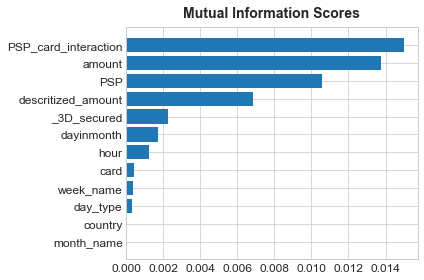

In [1227]:
experimenting_success_MI_on_features(['country', 'amount',  'PSP', '_3D_secured', 'card',
            'hour',  'week_name', 'day_type', 'month_name',
           'dayinmonth', 'descritized_amount', 'PSP_card_interaction'])

PSP_card_interaction    0.014981
amount                  0.013732
PSP                     0.010564
_3D_secured             0.002266
hour                    0.001248
card                    0.000444
day_type                0.000296
country                 0.000008
Name: MI Scores, dtype: float64

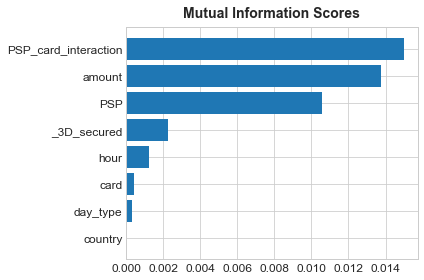

In [1228]:
experimenting_success_MI_on_features(['country', 'amount',  'PSP', '_3D_secured', 'card',
        'hour',   'day_type', 
       'PSP_card_interaction'])

In [1229]:
# convert the hour into two separate features using sine and cosine functions. 
# This way, the model can understand the circular nature of the data.
df['sine_hour'] = np.sin(2 * np.pi * df['hour'] / 24)
df['cosine_hour'] = np.cos(2 * np.pi * df['hour'] / 24)

PSP_card_interaction    0.014981
amount                  0.013732
PSP                     0.010564
_3D_secured             0.002266
dayinmonth              0.001700
sine_hour               0.001471
hour                    0.001248
card                    0.000444
day_type                0.000296
country                 0.000008
Name: MI Scores, dtype: float64

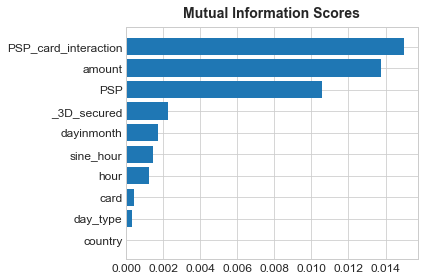

In [1230]:
experimenting_success_MI_on_features(['country', 'amount',  'PSP', '_3D_secured', 'card',
        'hour',  'day_type', 
       'dayinmonth',  'PSP_card_interaction', 'sine_hour'])

In [1231]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40461 entries, 1 to 50409
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   tmsp                  40461 non-null  datetime64[ns]
 1   country               40461 non-null  category      
 2   amount                40461 non-null  int64         
 3   success               40461 non-null  int64         
 4   PSP                   40461 non-null  category      
 5   _3D_secured           40461 non-null  int64         
 6   card                  40461 non-null  category      
 7   date                  40461 non-null  datetime64[ns]
 8   hour                  40461 non-null  int64         
 9   fee                   40461 non-null  float64       
 10  week_name             40461 non-null  category      
 11  day_type              40461 non-null  category      
 12  month_name            40461 non-null  category      
 13  dayinmonth      

In [1232]:
# before delving into training model.
# we are sure that
# features importance explored by mutual information 
# no nan values
# outliers removed, (explored by boxlpot)
# no skewed features
# target feature will be 'success' (imbalanced feature)27174 unsuccessful, 10053 successful 
# we may first experimenting on balanced data

In [1233]:
def create_balanced_data_from(df):
    print('before undersampling majority class', df.shape[0])
    # creating balanced data
    df_sucessfull=df.query('success == 1')
    print('successful_transactions', df_sucessfull.shape[0])
    #undersampling majority class
    df_failure=df.query('success == 0').sample(int(df_sucessfull.shape[0]), random_state=42)
    print('failed_transactions', df_failure.shape[0])
    #merge to create balanced data
    df_balanced=pd.concat([df_sucessfull, df_failure])
    print('balanced dataset',df_balanced.shape[0])
    return df_balanced


In [1234]:
def scaling(df):
    scaler=MinMaxScaler()
    df[['amount']] = scaler.fit_transform(df[['amount']])
    return df

In [1235]:
def scaling_testing(df):
    df[['amount']] = scaler.transform(df[['amount']])
    return df

In [1236]:
# training_features=['PSP', '_3D_secured', 'card', 'descritized_amount' ] 

In [1237]:
def _by_label_encoding(df, training_features):
    for colname in df[training_features].select_dtypes(['category', 'object']):
        df[colname]=df[colname].cat.codes
    return df


In [1238]:
def _by_one_hot_encoding(df, one_hot_features):
    """define desired categorical features, will drop the first to avoid collinearity,(list) """
    one_hot_encoded=pd.get_dummies(df[one_hot_features], drop_first=True)
    df_encoded=df.drop(one_hot_features, axis=1)
    df_encoded=df_encoded.join(one_hot_encoded)
    training_features_hot_encoded=list(one_hot_encoded.columns)
    
    not_encoded= [each for each in training_features if each not in one_hot_features]
    new_training_features=not_encoded+training_features_hot_encoded
    print('not_encoded columns are \n',not_encoded)
    print('one_hot_encoded columns are \n',training_features_hot_encoded)
    return df_encoded, new_training_features

In [1239]:
# commenting out no significant progress
# def _by_target_encoding(df_balanced):
#     encoder = TargetEncoder(sparse=False)
#     df_balanced[training_features] = encoder.fit_transform(X=df_balanced[training_features], y= df_balanced['success'])   
#     return df_balanced

In [1240]:
# lets create a model for predicting success rate from other input features.
# preparing for base models

def splitting(df, training_features):
    X_train, X_test, y_train, y_test = train_test_split(df[training_features], df['success'], test_size=0.2, random_state=42)
    return X_train, X_test, y_train, y_test

In [1241]:
def base_models_score(X_train, X_test, y_train, y_test):
    display(X_train.columns)
    clf = DecisionTreeClassifier()
    rf_model = RandomForestClassifier(random_state=42)
    ada_model = AdaBoostClassifier(random_state=42)
    knn_model = KNeighborsClassifier()
    naive_model=MultinomialNB()
    xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
    for each_model in [clf, rf_model, ada_model, knn_model ,naive_model,xgb_model ]:
        each_model.fit(X_train, y_train)
        # Make predictions
        y_pred = each_model.predict(X_test)
        # Evaluate the model
        (accuracy, recall, precision, fscore) = (accuracy_score(y_true=y_test, y_pred=y_pred), 
                                         recall_score(y_true=y_test, y_pred=y_pred),
                                         precision_score(y_true=y_test, y_pred=y_pred),
                                                fbeta_score(y_true=y_test, y_pred=y_pred, beta=0.5)
                                                         )

        print(f'Accuracy for {each_model}:\n {accuracy * 100:.2f}%',f'recall: {recall * 100:.2f}%', f'precision: {precision* 100:.2f}%', f'fscore: {fscore* 100:.2f}%' )


In [1242]:
# # experimenting accuracy when removing outliers from 'amount'
# tobedeleted=df_balanced[df_balanced['amount'] >450].index 
# #from the previous histogram, we deleted the farthest skewed tail
# df_balanced.drop(tobedeleted, inplace=True)
# #after removing the farthest right skewed tail in 'amount', (resulted in lower accuracy)


In [1243]:
training_features=[ 'PSP_card_interaction', 'amount', 'day_type', '_3D_secured', 'dayinmonth', 'week_name', 'month_name']
df_balanced=create_balanced_data_from(df)
# display(df_balanced.head(1))
# df_balanced=scaling(df_balanced)
# (one hot_ encoding for certain features)
(df_encoded, new_training_features)=_by_one_hot_encoding(df_balanced, [  'PSP_card_interaction','week_name'])

# (label_ encoding)
df_encoded=_by_label_encoding(df_encoded,new_training_features )

before undersampling majority class 40461
successful_transactions 10206
failed_transactions 10206
balanced dataset 20412
not_encoded columns are 
 ['amount', 'day_type', '_3D_secured', 'dayinmonth', 'month_name']
one_hot_encoded columns are 
 ['PSP_card_interaction_Goldcard_Master', 'PSP_card_interaction_Goldcard_Visa', 'PSP_card_interaction_Moneycard_Diners', 'PSP_card_interaction_Moneycard_Master', 'PSP_card_interaction_Moneycard_Visa', 'PSP_card_interaction_Simplecard_Diners', 'PSP_card_interaction_Simplecard_Master', 'PSP_card_interaction_Simplecard_Visa', 'PSP_card_interaction_UK_Card_Diners', 'PSP_card_interaction_UK_Card_Master', 'PSP_card_interaction_UK_Card_Visa', 'week_name_Monday', 'week_name_Saturday', 'week_name_Sunday', 'week_name_Thursday', 'week_name_Tuesday', 'week_name_Wednesday']


In [1244]:
# all training features that will feed the model 
# encloding one hot and label and continuous
new_training_features 

['amount',
 'day_type',
 '_3D_secured',
 'dayinmonth',
 'month_name',
 'PSP_card_interaction_Goldcard_Master',
 'PSP_card_interaction_Goldcard_Visa',
 'PSP_card_interaction_Moneycard_Diners',
 'PSP_card_interaction_Moneycard_Master',
 'PSP_card_interaction_Moneycard_Visa',
 'PSP_card_interaction_Simplecard_Diners',
 'PSP_card_interaction_Simplecard_Master',
 'PSP_card_interaction_Simplecard_Visa',
 'PSP_card_interaction_UK_Card_Diners',
 'PSP_card_interaction_UK_Card_Master',
 'PSP_card_interaction_UK_Card_Visa',
 'week_name_Monday',
 'week_name_Saturday',
 'week_name_Sunday',
 'week_name_Thursday',
 'week_name_Tuesday',
 'week_name_Wednesday']

In [1245]:
# split data
X_train, X_test, y_train, y_test=splitting(df_encoded, new_training_features)
#train data and calculate evaluation scores
base_models_score(X_train, X_test, y_train, y_test)

Index(['amount', 'day_type', '_3D_secured', 'dayinmonth', 'month_name',
       'PSP_card_interaction_Goldcard_Master',
       'PSP_card_interaction_Goldcard_Visa',
       'PSP_card_interaction_Moneycard_Diners',
       'PSP_card_interaction_Moneycard_Master',
       'PSP_card_interaction_Moneycard_Visa',
       'PSP_card_interaction_Simplecard_Diners',
       'PSP_card_interaction_Simplecard_Master',
       'PSP_card_interaction_Simplecard_Visa',
       'PSP_card_interaction_UK_Card_Diners',
       'PSP_card_interaction_UK_Card_Master',
       'PSP_card_interaction_UK_Card_Visa', 'week_name_Monday',
       'week_name_Saturday', 'week_name_Sunday', 'week_name_Thursday',
       'week_name_Tuesday', 'week_name_Wednesday'],
      dtype='object')

Accuracy for DecisionTreeClassifier():
 54.20% recall: 51.87% precision: 54.75% fscore: 54.15%
Accuracy for RandomForestClassifier(random_state=42):
 55.79% recall: 56.16% precision: 56.07% fscore: 56.09%
Accuracy for AdaBoostClassifier(random_state=42):
 65.07% recall: 68.91% precision: 64.28% fscore: 65.15%
Accuracy for KNeighborsClassifier():
 54.00% recall: 51.97% precision: 54.52% fscore: 53.99%
Accuracy for MultinomialNB():
 58.46% recall: 58.35% precision: 58.80% fscore: 58.71%
Accuracy for XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=

In [1246]:
# save scores in excell

scores=pd.DataFrame({'features':[ [ 'PSP',  'PSP_card_interaction','amount','country', 'day_type','_3D_secured']],
     'encoding': 'one_hot',
   'best_model':'AdaBoostClassifier',
   'best_fscore': 64.28,
   'second_best_model':'XGBClassifier',
   'second_best_fscore':62.75
   })


In [1247]:
# add new score to the dataframe scores
new_row=[str(training_features),'one_hot','AdaBoostClassifier',65.15,'XGBClassifier',63.34]
scores.loc[len(scores)]=new_row

In [1248]:
# fbscore deteriorated in all base models in case of unbalanced data, despite 
# accuracy is highly elevated 74.64% for all base algorithms, in a trial for 
# unbalanced dataset, Fscore becomes 10.9, features 'PSP_card_interaction', 'amount', 'day_type', 
# '_3D_secured', 'dayinmonth', 'week_name', 'month_name'

In [1249]:
# scores.to_excel('scores.xlsx')

Best feaures are ['PSP_card_interaction', 'amount', 'day_type', '_3D_secured', 'dayinmonth', 'week_name', 'month_name']

the best base model is AdaBoostClassifier fbscore of 65.15 

the second best base model is XGBClassifier (63.34)

In [1250]:
#optimizing the model by grid search

In [1251]:
#commenting out because this optimization doesnt improve the fb score
# optimization by grid search


# # Define the base estimator for AdaBoost (using DecisionTreeClassifier)
# base_estimator = DecisionTreeClassifier(random_state=42)

# # Define AdaBoostClassifier with the base estimator
# clf = AdaBoostClassifier( random_state=42)

# # Add more parameters to the grid search
# parameters = {
#     'n_estimators': [50, 100, 200],  # Number of boosting rounds
#     'learning_rate': [0.01, 0.1, 1.0],  # Shrinks the contribution of each classifier
# #     'base_estimator__max_depth': [1, 2, 3],  # Depth of the base estimator (DecisionTreeClassifier)
#     'algorithm': ['SAMME', 'SAMME.R'],  # Two algorithms supported by AdaBoost
# }

# # Define the scorer using fbeta_score
# scorer = make_scorer(fbeta_score, beta=0.5)

# # GridSearchCV with the specified classifier, parameter grid, and scoring method
# grid_obj = GridSearchCV(clf, parameters, scoring=scorer, verbose=1)

# # Fit the model with the training data
# grid_fit = grid_obj.fit(X_train, y_train)

# # Extract the best model from the grid search
# best_clf = grid_fit.best_estimator_

# # Make predictions using the unoptimized and optimized models
# predictions = clf.fit(X_train, y_train).predict(X_test)
# best_predictions = best_clf.predict(X_test)

# # Report the scores before and after optimization
# print("Unoptimized model\n------")
# print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
# print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta=0.5)))

# print("\nOptimized Model\n------")
# print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
# print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta=0.5)))


before undersampling majority class 40461
successful_transactions 10206
failed_transactions 10206
balanced dataset 20412
not_encoded columns are 
 ['amount', 'day_type', '_3D_secured', 'dayinmonth', 'month_name']
one_hot_encoded columns are 
 ['PSP_card_interaction_Goldcard_Master', 'PSP_card_interaction_Goldcard_Visa', 'PSP_card_interaction_Moneycard_Diners', 'PSP_card_interaction_Moneycard_Master', 'PSP_card_interaction_Moneycard_Visa', 'PSP_card_interaction_Simplecard_Diners', 'PSP_card_interaction_Simplecard_Master', 'PSP_card_interaction_Simplecard_Visa', 'PSP_card_interaction_UK_Card_Diners', 'PSP_card_interaction_UK_Card_Master', 'PSP_card_interaction_UK_Card_Visa', 'week_name_Monday', 'week_name_Saturday', 'week_name_Sunday', 'week_name_Thursday', 'week_name_Tuesday', 'week_name_Wednesday']
fscore: 65.15%


['adaboost_model.joblib']

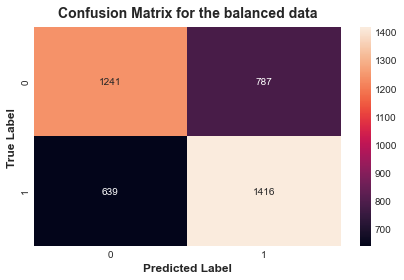

In [1252]:
# Writing adaboost model alone
training_features=['PSP_card_interaction', 'amount', 'day_type', '_3D_secured', 'dayinmonth', 'week_name', 'month_name']
df_balanced=create_balanced_data_from(df)

(df_encoded, new_training_features)=_by_one_hot_encoding(df_balanced, [ 'PSP_card_interaction','week_name'])
df_encoded=_by_label_encoding(df_encoded,new_training_features )

ada_model = AdaBoostClassifier(random_state=42)
ada_model.fit(X_train, y_train)
y_pred = ada_model.predict(X_test)

fscore = fbeta_score(y_true=y_test, y_pred=y_pred, beta=0.5)

print( f'fscore: {fscore* 100:.2f}%' )
sns.heatmap(confusion_matrix(y_true=y_test, y_pred=y_pred), annot=True, fmt='d')
plt.xlabel('Predicted Label')  
plt.ylabel('True Label')       

# Optionally, add a title  
plt.title('Confusion Matrix for the balanced data') 

joblib.dump(ada_model, 'adaboost_model.joblib')

not_encoded columns are 
 ['amount', 'day_type', '_3D_secured', 'dayinmonth', 'month_name']
one_hot_encoded columns are 
 ['PSP_card_interaction_Goldcard_Master', 'PSP_card_interaction_Goldcard_Visa', 'PSP_card_interaction_Moneycard_Diners', 'PSP_card_interaction_Moneycard_Master', 'PSP_card_interaction_Moneycard_Visa', 'PSP_card_interaction_Simplecard_Diners', 'PSP_card_interaction_Simplecard_Master', 'PSP_card_interaction_Simplecard_Visa', 'PSP_card_interaction_UK_Card_Diners', 'PSP_card_interaction_UK_Card_Master', 'PSP_card_interaction_UK_Card_Visa', 'week_name_Monday', 'week_name_Saturday', 'week_name_Sunday', 'week_name_Thursday', 'week_name_Tuesday', 'week_name_Wednesday']


Text(0.5, 1.0, 'Confusion Matrix for unbalanced data')

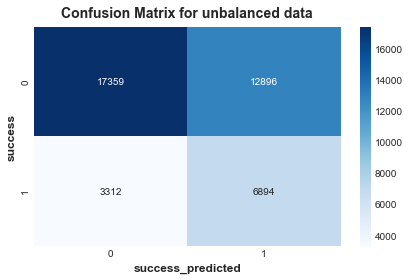

In [1253]:
#we will use this model to predict the whole dataset
df_for_model=df.copy()
df_for_model=df_for_model[training_features]

(df_encoded, new_training_features)=_by_one_hot_encoding(df_for_model, [ 'PSP_card_interaction','week_name'])
df_encoded=_by_label_encoding(df_encoded,new_training_features )

ada_model = joblib.load('adaboost_model.joblib')
#predict success as binary
df['success_predicted']=ada_model.predict(df_encoded[new_training_features])
#predict success as probability
probabilities = ada_model.predict_proba(df_encoded[new_training_features])
positive_class_probabilities = probabilities[:, 1]
df['success_predicted_probability']=positive_class_probabilities

sns.heatmap(confusion_matrix(y_true=df['success'], y_pred=df['success_predicted']), annot=True, fmt='d',cmap='Blues')
plt.xlabel("success_predicted")
plt.ylabel("success")
plt.title("Confusion Matrix for unbalanced data")

(0.0, 100.0)

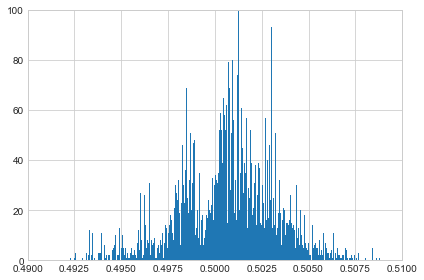

In [1254]:
df.query('success ==1').success_predicted_probability.hist(bins=1000)
plt.xlim(0.49, 0.51)  # Set the x-axis limits  
plt.ylim(0,100)  

In [1255]:
(df.query('success == 1')).success_predicted.mean()

0.6754850088183422

(0.0, 1000.0)

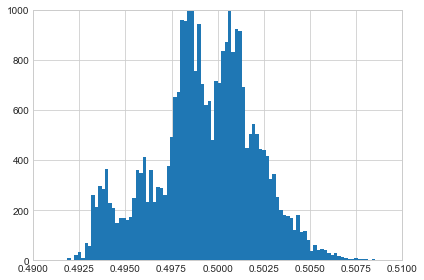

In [1256]:
df.query('success ==0').success_predicted_probability.hist(bins=1000)
plt.xlim(0.49, 0.51)  # Set the x-axis limits  
plt.ylim(0,1000)  

In [1257]:
(df.query('success == 0')).success_predicted.mean()

0.4262435960998182

### Routing process

In [1258]:

#to Nominate the best fitted PSP for any transaction settings: 
#1 we need first to predict succeess as both a binary and probability columns. for a new record
#3 compare different PSP possibilities in terms of predicted_success.
#4 choose transactions which predicted as succeeded 
# then choose the least payment, 
#5 if all 4 possibilities are predicted as 
# unsuccessful, then choose directly the least payment

# suppose a new record retrieved from the online system as a dictionary.
# for example this record
record=pd.DataFrame({'tmsp':['2019-01-01 00:12:52'],
     'country': 'Austria',
   'amount':232,
   'success':np.nan,
   'PSP':np.nan,
   '_3D_secured':1,
     'card':'Diners'             
   })

In [1259]:
#extracting_features for a record
recored=extract_date(record)
record=extracting_day_type(record)
record=extracting_month_name(record)
record=extracting_week_name(record)
record=extracting_day_in_month(record)
_4possibilities_are=record.copy()

# add different PSP possibilities for a record
_4possibilities_are.loc[:, 'PSP']='Moneycard'
for each in ['Goldcard', 'UK_Card', 'Simplecard']:
    _4possibilities_are = _4possibilities_are.append(record, ignore_index=True) 
    _4possibilities_are.at[len(_4possibilities_are) - 1, 'PSP'] =each
_4possibilities_are=interaction_PSP_card(_4possibilities_are)

# define the original training features used to train the model.
# This is the training features before encoding.
training_features=['PSP_card_interaction', 'amount', 'day_type', '_3D_secured', 'dayinmonth', 'week_name', 'month_name']

#encoding:
(record_df_encoded, record_new_training_features)=_by_one_hot_encoding(_4possibilities_are, [ 'PSP_card_interaction','week_name'])
record_df_encoded=_by_label_encoding(record_df_encoded, record_new_training_features )

# Align the record possibilities to have the same
# columns which the model adapted with.
#this the training features after encoding.
new_training_features=['amount',
 'day_type',
 '_3D_secured',
 'dayinmonth',
 'month_name',
 'PSP_card_interaction_Goldcard_Master',
 'PSP_card_interaction_Goldcard_Visa',
 'PSP_card_interaction_Moneycard_Diners',
 'PSP_card_interaction_Moneycard_Master',
 'PSP_card_interaction_Moneycard_Visa',
 'PSP_card_interaction_Simplecard_Diners',
 'PSP_card_interaction_Simplecard_Master',
 'PSP_card_interaction_Simplecard_Visa',
 'PSP_card_interaction_UK_Card_Diners',
 'PSP_card_interaction_UK_Card_Master',
 'PSP_card_interaction_UK_Card_Visa',
 'week_name_Monday',
 'week_name_Saturday',
 'week_name_Sunday',
 'week_name_Thursday',
 'week_name_Tuesday',
 'week_name_Wednesday']

new_data_final = pd.DataFrame(columns=new_training_features) 

#in the new_data_final, get or copy values from record_df_encoded for same columns
# otherwise, write 0s for columns that are not present
for col in new_training_features:  
    new_data_final[col] = record_df_encoded.get(col, 0)  
    
#prediction
ada_model = joblib.load('adaboost_model.joblib')

# classification task
_4possibilities_are['success_predicted']=ada_model.predict(new_data_final[new_training_features])
#predict probabilities
probabilities = ada_model.predict_proba(new_data_final[new_training_features])
_4possibilities_are['success_predicted_probability']= probabilities[:, 1]

not_encoded columns are 
 ['amount', 'day_type', '_3D_secured', 'dayinmonth', 'month_name']
one_hot_encoded columns are 
 ['PSP_card_interaction_Moneycard_Diners', 'PSP_card_interaction_Simplecard_Diners', 'PSP_card_interaction_UK_Card_Diners']


In [1260]:
_4possibilities_are

,tmsp,country,amount,success,PSP,_3D_secured,card,date,day_type,month_name,week_name,dayinmonth,PSP_card_interaction,success_predicted,success_predicted_probability
0,2019-01-01 00:12:52,Austria,232,NaN,Moneycard,1,Diners,2019-01-01,Working Day,January,Tuesday,1,Moneycard_Diners,1,0.503450
1,2019-01-01 00:12:52,Austria,232,NaN,Goldcard,1,Diners,2019-01-01,Working Day,January,Tuesday,1,Goldcard_Diners,1,0.503450
2,2019-01-01 00:12:52,Austria,232,NaN,UK_Card,1,Diners,2019-01-01,Working Day,January,Tuesday,1,UK_Card_Diners,1,0.502675
3,2019-01-01 00:12:52,Austria,232,NaN,Simplecard,1,Diners,2019-01-01,Working Day,January,Tuesday,1,Simplecard_Diners,1,0.502588


In [1261]:
# a simple routing process is (depends on the binary column):
#1 add fees according to success predicted
_4possibilities_are=incorporate_fee_into_table(_4possibilities_are, 'success_predicted')
#2 look only to rows prdedicted as successful, choose the least fee. 
display(_4possibilities_are)
try: #get the least payment  for successful transactions
    succ_=_4possibilities_are.query('success_predicted==1')
    record['routed']=np.nan
    record.loc[:,'routed']=succ_.loc[succ_['fee'].idxmin(), 'PSP']
#3 if there is no rows predicted as successful, choose the least fee. 
except: #otherwise choose the least payment. (when all PSP possibilities return unsuccessful)
    unsucc_=_4possibilities_are.copy()
    record.loc[:,'routed']=succ_.loc[unsucc_.loc['fee'].idxmin(),'PSP']
record

,tmsp,country,amount,success,PSP,_3D_secured,card,date,day_type,month_name,week_name,dayinmonth,PSP_card_interaction,success_predicted,success_predicted_probability,fee
0,2019-01-01 00:12:52,Austria,232,NaN,Moneycard,1,Diners,2019-01-01,Working Day,January,Tuesday,1,Moneycard_Diners,1,0.503450,5.0
1,2019-01-01 00:12:52,Austria,232,NaN,Goldcard,1,Diners,2019-01-01,Working Day,January,Tuesday,1,Goldcard_Diners,1,0.503450,10.0
2,2019-01-01 00:12:52,Austria,232,NaN,UK_Card,1,Diners,2019-01-01,Working Day,January,Tuesday,1,UK_Card_Diners,1,0.502675,3.0
3,2019-01-01 00:12:52,Austria,232,NaN,Simplecard,1,Diners,2019-01-01,Working Day,January,Tuesday,1,Simplecard_Diners,1,0.502588,1.0


,tmsp,country,amount,success,PSP,_3D_secured,card,date,day_type,month_name,week_name,dayinmonth,routed
0,2019-01-01 00:12:52,Austria,232,NaN,NaN,1,Diners,2019-01-01,Working Day,January,Tuesday,1,Simplecard


In [1262]:
# If our periority is toward raise success rate, than lowering fees.

# then a more sophisticated routing process, but may
# be more accurate is to uitilize the advantage of  success probability column 
# created from the model, the workflow then will be:

#1 add to the record both fees in case of success and failure.
#2 calculate payment expectation 
#    E  =  p(success) * success_fee   +   (1-p(success)  *  failure_fee
#3 look only to 2 rows having highest probabilities.(sort and deal with the first 2)
#     if the difference between the 2 probabilities is lower than a threshold:
#         choose the least payment expectation.
#      else: 
#         choose the highest probability.


# in this routing process we choose the possibility which has higher success probability, 
# if it is evident that the getting a successful transaction is more financially useful than 
# considering less payment fees, if two or more different probabilities are
# so close, we can then vote for the less payment. in this situation a threshold must be defined to tell 
# when to consider them as 'close', this needs integrated research with the revenue
# gained from successful transaction.
# and in this case it is recommended to use recall for model optimization.

# in our experiment multinomial classifiers with features ['PSP', 'PSP_card_interaction', 
# 'descritized_amount', 'country', 'day_type', '_3D_secured']
# gives higher recall rate 69.49, than this Adaboost recall score.(68.91)


In [1263]:
record['routed_sophisticated']=np.nan
# this more sophisticated routing process depends on the probability column:
#1 add two columns fees (success and failure)
fee = pd.DataFrame({
    'name': ['Moneycard', 'Goldcard', 'UK_Card', 'Simplecard'],
    'Fee on successful transactions(EURO)': [5, 10, 3, 1],
    'Fee on failed transactions': [2, 5, 1, 0.5]
      })
_4possibilities_are['fee_success']=np.nan
_4possibilities_are['fee_failure']=np.nan
for each in range(fee.shape[0]):
    _4possibilities_are.loc[(_4possibilities_are.PSP==fee.iloc[each, 0]) , 'fee_success']=fee.iloc[each, 1] 
    # means if the first name in fee table equal the name of PSP, then write in fee_success column. 
    _4possibilities_are.loc[(_4possibilities_are.PSP==fee.iloc[each, 0]) , 'fee_failure']=fee.iloc[each, 2] 

#2 calculate payment expectation 
_4possibilities_are['payment_expectation']=_4possibilities_are['fee_success']*_4possibilities_are['success_predicted_probability']+_4possibilities_are['fee_failure']*(1-_4possibilities_are['success_predicted_probability'])
display('this is all 4 possibilities ',_4possibilities_are)

#routing
#3 look only to 2 rows having highest probabilities.(sort and deal with the first 2)
_4possibilities_are = _4possibilities_are.sort_values(by='success_predicted_probability', ascending=False)
_highest2possibilities_are = _4possibilities_are.iloc[:2]

# Calculate the difference  
difference = _4possibilities_are.loc[0, 'success_predicted_probability'] - _4possibilities_are.loc[1, 'success_predicted_probability']  

#     if the difference between the 2 probabilities is lower than a threshold:

if difference < 0.0025:
#         choose the least payment expectation.
    record.loc[:,'routed_sophisticated']=_highest2possibilities_are.loc[_highest2possibilities_are['payment_expectation'].idxmin(), 'PSP']
#      else: 
#         choose the highest probability.( from all )
else: 
    record.loc[:,'routed_sophisticated']=_4possibilities_are.loc[_4possibilities_are['success_predicted_probability'].idxmax(), 'PSP']

display('routed_sophisticated', record)


'this is all 4 possibilities '

,tmsp,country,amount,success,PSP,_3D_secured,card,date,day_type,month_name,week_name,dayinmonth,PSP_card_interaction,success_predicted,success_predicted_probability,fee,fee_success,fee_failure,payment_expectation
0,2019-01-01 00:12:52,Austria,232,NaN,Moneycard,1,Diners,2019-01-01,Working Day,January,Tuesday,1,Moneycard_Diners,1,0.503450,5.0,5.0,2.0,3.510349
1,2019-01-01 00:12:52,Austria,232,NaN,Goldcard,1,Diners,2019-01-01,Working Day,January,Tuesday,1,Goldcard_Diners,1,0.503450,10.0,10.0,5.0,7.517248
2,2019-01-01 00:12:52,Austria,232,NaN,UK_Card,1,Diners,2019-01-01,Working Day,January,Tuesday,1,UK_Card_Diners,1,0.502675,3.0,3.0,1.0,2.005349
3,2019-01-01 00:12:52,Austria,232,NaN,Simplecard,1,Diners,2019-01-01,Working Day,January,Tuesday,1,Simplecard_Diners,1,0.502588,1.0,1.0,0.5,0.751294


'routed_sophisticated'

,tmsp,country,amount,success,PSP,_3D_secured,card,date,day_type,month_name,week_name,dayinmonth,routed,routed_sophisticated
0,2019-01-01 00:12:52,Austria,232,NaN,NaN,1,Diners,2019-01-01,Working Day,January,Tuesday,1,Simplecard,Moneycard


In [1264]:
# in this sphisticated routing example Money card is prefered from Simple card,
# despite payment expectation is 3.510349 and 0.751294 for moneycard and simplecard respectively,
# but the routing gives weight of significant more to the higher probability transaction, for other 
# reasons (like revenue from successful transactions ans customer satisfaction).

## Deployment

In [1265]:
# this section should be copied to a .py file to create user interface with 
# streamli application.
import streamlit as st
import joblib
import numpy as np
import pandas as pd
from datetime import datetime
import help_functions
# Load the pre-trained model
model = joblib.load("adaboost_model.joblib")

# Set up Streamlit UI
st.title("Route for best PSP")
st.write("Enter inputs  to predict the best PSP:")

# Input fields for iris flower features
amount = st.number_input("amount (euro)", min_value=0.0, max_value=10.0, value=5.0, step=0.1)

_3D_secured = ["0", "1"]
_3D_secured = st.selectbox("_3d_secured", _3D_secured)

country = ["Germany", "Switzerland", "Austria"]
country = st.selectbox("country", country)

#Success = ["0", "1"]
#Success = st.selectbox("Success", Success)
Success=np.nan
PSP=np.nan

card = ["Master", "Visa", "Diners"]
card = st.selectbox("card", card)

# Timestamp input
date = st.date_input("Date")
time = st.time_input("Time")
tmsp = datetime.combine(date, time)  # Combine date and time into a single datetime object


#routin process
recored=extract_date(record)
record=extracting_day_type(record)
record=extracting_month_name(record)
record=extracting_week_name(record)
record=extracting_day_in_month(record)
_4possibilities_are=record.copy()

# add different PSP possibilities for a record
_4possibilities_are.loc[:, 'PSP']='Moneycard'
for each in ['Goldcard', 'UK_Card', 'Simplecard']:
    _4possibilities_are = _4possibilities_are.append(record, ignore_index=True) 
    _4possibilities_are.at[len(_4possibilities_are) - 1, 'PSP'] =each
_4possibilities_are=interaction_PSP_card(_4possibilities_are)

# define the original training features used to train the model.
# This is the training features before encoding.
training_features=['PSP_card_interaction', 'amount', 'day_type', '_3D_secured', 'dayinmonth', 'week_name', 'month_name']

#encoding:
(record_df_encoded, record_new_training_features)=_by_one_hot_encoding(_4possibilities_are, [ 'PSP_card_interaction','week_name'])
record_df_encoded=_by_label_encoding(record_df_encoded, record_new_training_features )

# Align the record possibilities to have the same
# columns which the model adapted with.
#this the training features after encoding.
new_training_features=['amount',
 'day_type',
 '_3D_secured',
 'dayinmonth',
 'month_name',
 'PSP_card_interaction_Goldcard_Master',
 'PSP_card_interaction_Goldcard_Visa',
 'PSP_card_interaction_Moneycard_Diners',
 'PSP_card_interaction_Moneycard_Master',
 'PSP_card_interaction_Moneycard_Visa',
 'PSP_card_interaction_Simplecard_Diners',
 'PSP_card_interaction_Simplecard_Master',
 'PSP_card_interaction_Simplecard_Visa',
 'PSP_card_interaction_UK_Card_Diners',
 'PSP_card_interaction_UK_Card_Master',
 'PSP_card_interaction_UK_Card_Visa',
 'week_name_Monday',
 'week_name_Saturday',
 'week_name_Sunday',
 'week_name_Thursday',
 'week_name_Tuesday',
 'week_name_Wednesday']

new_data_final = pd.DataFrame(columns=new_training_features) 



#in the new_data_final, get or copy values from record_df_encoded for same columns
# otherwise, write 0s for columns that are not present
for col in new_training_features:  
    new_data_final[col] = record_df_encoded.get(col, 0)  
    
#prediction
ada_model = joblib.load('adaboost_model.joblib')

# classification task
_4possibilities_are['success_predicted']=ada_model.predict(new_data_final[new_training_features])
#predict probabilities
probabilities = ada_model.predict_proba(new_data_final[new_training_features])
_4possibilities_are['success_predicted_probability']= probabilities[:, 1]

# a simple routing process is (depends on the binary column):
#1 add fees according to success predicted
_4possibilities_are=incorporate_fee_into_table(_4possibilities_are, 'success_predicted')
#2 look only to rows prdedicted as successful, choose the least fee. 
try: #get the least payment  for successful transactions
    succ_=_4possibilities_are.query('success_predicted==1')
    record['routed']=np.nan
    record.loc[:,'routed']=succ_.loc[succ_['fee'].idxmin(), 'PSP']
#3 if there is no rows predicted as successful, choose the least fee. 
except: #otherwise choose the least payment. (when all PSP possibilities return unsuccessful)
    unsucc_=_4possibilities_are.copy()
    record.loc[:,'routed']=succ_.loc[unsucc_.loc['fee'].idxmin(),'PSP']
record


# Prediction
if st.button("Predict"):
    features = np.array([[tmsp, country, amount,success, PSP,_3D_secured, card]])

    
    st.write(f"The predicted transaction type is: **{record}**")


ModuleNotFoundError: No module named 'help_functions'